In [6]:
from cfl.experiment import Experiment
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from cfl_helpers import *

In [7]:
resolution = '4km'
train_file = f'data/{resolution}_data.csv'
test_file = f'data/13km_truth.csv'

train_data = pd.read_csv(train_file)
trainX, trainY = np.array(train_data[['lat', 'long']]), np.array(train_data['generated_temp']).reshape(-1,1)
trainX = StandardScaler().fit_transform(trainX)
trainY = StandardScaler().fit_transform(trainY)

test_data = pd.read_csv(test_file)
del test_data['elevation']
testX, testY = np.array(test_data[['lat', 'long']]), np.array(test_data['generated_temp']).reshape(-1,1)
testX = StandardScaler().fit_transform(testX)
testY = StandardScaler().fit_transform(testY)

print('Training data shape:', trainX.shape, trainY.shape)
print('Test data shape:', testX.shape, testY.shape)

Training data shape: (79459, 2) (79459, 1)
Test data shape: (7487, 2) (7487, 1)


In [8]:
data_info = {'X_dims' : trainX.shape,
             'Y_dims' : trainY.shape,
             'Y_type' : 'continuous' #options: 'categorical' or 'continuous'
            }

CDE_params = {  'model'        : 'CondExpMod',
                'model_params' : {
                    # model architecture
                    'dense_units' : [50, data_info['Y_dims'][1]],
                    'activations' : ['relu', 'linear'],
                    'dropouts'    : [0, 0],
                    # training parameters
                    'batch_size'  : 64,
                    'n_epochs'    : 2000,
                    'optimizer'   : 'adam',
                    'opt_config'  : {'lr' : 1e-4},
                    'loss'        : 'mean_squared_error',
                    'best'        : True,
                    'early_stopping' : True,
                    # verbosity
                    'verbose'     : 0, # don't log or show plot for checking clusters vs accuracy
                    'show_plot'   : False,
                }
}

# CAUSE CLUSTER PARAMS VARIED

In [9]:
'''
# old tests for checking clusters

cause_cluster_params =  {'model' : 'KMeans',
                        'model_params' : {'n_clusters' : 10},
                        'verbose' : 0
}

block_names = ['CondDensityEstimator', 'CauseClusterer']
block_params = [CDE_params, cause_cluster_params]
results_path = 'sample' # directory to save results to

my_exp = Experiment(X_train=trainX,
                    Y_train=trainY,
                    data_info=data_info,
                    block_names=block_names,
                    block_params=block_params,
                    results_path=results_path)
results = my_exp.train()
xlbls = results['CauseClusterer']['x_lbls']

my_exp.add_dataset(X=testX, Y=testY, dataset_name='test_data')
pred_results = my_exp.predict('test_data')
pred_xlbls = pred_results['CauseClusterer']['x_lbls']

# print(xlbls) # on 40km dataset
train_lbl_avg, train_lbl_dict = get_group_avgs(train_data, xlbls)
print(train_lbl_avg)
train_counts = {i: len(train_lbl_dict[i]) for i in range(10)}
counts_sum = sum(train_counts.values())
train_counts_prop = {k: round(v / counts_sum, 2) for k, v in train_counts.items()}
print(train_counts_prop)

test_lbl_avg, test_lbl_dict = get_group_avgs(test_data, pred_xlbls)
preds = list(pred_xlbls)

print()
print(test_lbl_avg)
test_counts = {i: len(test_lbl_dict[i]) for i in range(10)}
counts_sum = sum(test_counts.values())
test_counts_prop = {k: round(v / counts_sum, 2) for k, v in test_counts.items()}
print(test_counts_prop)
'''

"\n# old tests for checking clusters\n\ncause_cluster_params =  {'model' : 'KMeans',\n                        'model_params' : {'n_clusters' : 10},\n                        'verbose' : 0\n}\n\nblock_names = ['CondDensityEstimator', 'CauseClusterer']\nblock_params = [CDE_params, cause_cluster_params]\nresults_path = 'sample' # directory to save results to\n\nmy_exp = Experiment(X_train=trainX,\n                    Y_train=trainY,\n                    data_info=data_info,\n                    block_names=block_names,\n                    block_params=block_params,\n                    results_path=results_path)\nresults = my_exp.train()\nxlbls = results['CauseClusterer']['x_lbls']\n\nmy_exp.add_dataset(X=testX, Y=testY, dataset_name='test_data')\npred_results = my_exp.predict('test_data')\npred_xlbls = pred_results['CauseClusterer']['x_lbls']\n\n# print(xlbls) # on 40km dataset\ntrain_lbl_avg, train_lbl_dict = get_group_avgs(train_data, xlbls)\nprint(train_lbl_avg)\ntrain_counts = {i: le

In [10]:
# n_clusters = [1, 5, 10, 30, 50, 75, 100, 150, 200] # for 10km
# n_clusters = [1, 3, 5, 7, 10, 15, 20, 30, 50, 100, 200] # for 25km
n_clusters = [1, 2, 3, 5, 7, 10, 15, 20, 30, 40, 50] # for 40km

sq_errs = []

for n in n_clusters:
    cause_cluster_params =  {'model' : 'KMeans',
                         'model_params' : {'n_clusters' : n},
                         'verbose' : 0
    }

    block_names = ['CondDensityEstimator', 'CauseClusterer']
    block_params = [CDE_params, cause_cluster_params]
    results_path = 'sample_run_2' # directory to save results to

    my_exp = Experiment(X_train=trainX,
                        Y_train=trainY,
                        data_info=data_info,
                        block_names=block_names,
                        block_params=block_params,
                        results_path=results_path)
    results = my_exp.train()
    xlbls = results['CauseClusterer']['x_lbls']

    my_exp.add_dataset(X=testX, Y=testY, dataset_name='test_data')
    pred_results = my_exp.predict('test_data')
    pred_xlbls = pred_results['CauseClusterer']['x_lbls']

    sq_errs.append(by_cluster_err(train_data, xlbls, test_data, pred_xlbls))
    print(f'sq_err for {n} clusters: {sq_errs[-1]}')


All results from this run will be saved to sample_run_2/experiment0036
Block: verbose not specified in input, defaulting to 1
#################### Beginning CFL Experiment training. ####################
Beginning CondDensityEstimator training...
2484/2484 [==============================] - 3s 1ms/step
CondDensityEstimator training complete.
Beginning CauseClusterer training...
CauseClusterer training complete.
Experiment training complete.
Beginning Experiment prediction.
Beginning CondDensityEstimator prediction...
234/234 [==============================] - 0s 1ms/step
CondDensityEstimator prediction complete.
Beginning CauseClusterer prediction...
CauseClusterer prediction complete.
Prediction complete.
sq_err for 1 clusters: 3.159016489045022
All results from this run will be saved to sample_run_2/experiment0037
#################### Beginning CFL Experiment training. ####################
Beginning CondDensityEstimator training...


KeyboardInterrupt: 

[3.161871433350474, 2.1316918759628085, 1.8326822556137639, 1.7380466217091217, 1.9156964465807145, 1.875210099270421, 1.9638118277348604, 2.05319817296166, 1.8557054114031089, 1.971588101553395, 1.8336166163766392]


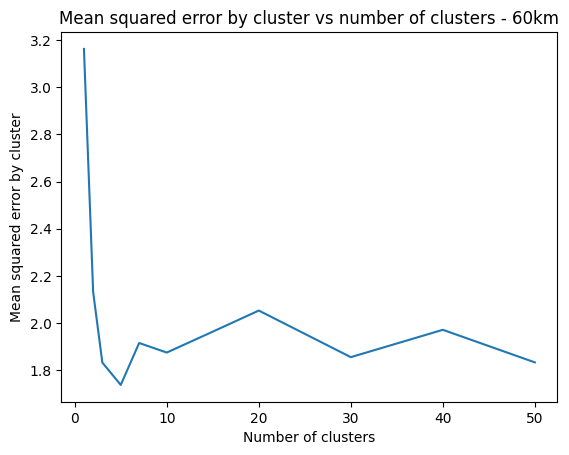

In [ ]:
import matplotlib.pyplot as plt

print(sq_errs)

plt.figure(0)
plt.plot(n_clusters, sq_errs)
plt.xlabel('Number of clusters')
plt.ylabel('Mean squared error by cluster')
_ = plt.title(f'Mean squared error by cluster vs number of clusters - {resolution}')

In [ ]:
print(xlbls)
print(pred_xlbls)

[15 47 39  3  8  0 15 12 29  1 27 38 18 14 18 25 21 27 20 43 37 15 47 14
 39  8  0 15  2 30 36 27 38 18 49  3 25  7 12 29  4 37 15 47 14 49  8  0
  6 20 43 36 27 38  8 32  3 47 15  2  1  4 37 15 47 39 49  8  7 12 29 42
 28 43 36 27 38  8 32  3  0 27 36 22 11  1  4 37 15 17  3 14 25 15 37 29
 11 28 43 36 46 21  8 14  8 21 27 20 11 28  1  4 37 45 40 18 39 47 41 12
 13  9 11 28 42 43 36 46 21 48 39 18  0 45  2  4 11 28 28 42  1  4  2 15
 17 18 14 48  7 46 13 28 42 42 42  1  9 36  6 38  8 39  3 17 45 36 42  1
  1  1  1 24 29 19  7 47 18 49  8 41 20  1 24 24 24 24  9  4 34 45  0  8
 39  3  7 26 24  9  9  9 43 30  4 26 27 21 25  8  8 21  2  9 43 22 22 30
 29 13 36 12 41  0 40 40 21 37 43 22 30  4 13 36 26 26  2  6 41 41 41 41
 34 22 30  4 13 20  2 34 37  2 34 19 46 46 46 34 30  4 13 26 37 19 46 12
 37 20 20 26 26 26 20  4 13 26 34 46  6  6 27  2 13  4  4  4  4  4 30 26
 34 27 45 15 15 46 26  4 43  9 24 24 24 24 34 27 45 41 21 41 19 20 30 24
 28 11 31 31 31 27 45  7 38 38 15 12 36 30 42 31 23